In [26]:
class Config:
    batch_size = 128
    validation_split = 0.15
    epochs = 10
    dataset_path = "/kaggle/input/llm-detect-ai-generated-text"
    output_dataset_path = "/kaggle/input/llm-ai-generated-text-detector"
    label = "generated"
    model_name = "distil_bert_base_en_uncased"
    is_training = False
config = Config()

In [27]:
import pandas as pd
import tensorflow as tf
import pathlib
import random
import string
import re
import sys
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import os
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer 
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.stats import rankdata
import json
import keras_nlp
import matplotlib.pyplot as plt

In [28]:
train_df = pd.read_csv(f"{config.dataset_path}/train_essays.csv")
train_df.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [29]:
test_df = pd.read_csv(f"{config.dataset_path}/test_essays.csv")
test_df.head()

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [30]:
train_prompts = pd.read_csv(f"{config.dataset_path}/train_prompts.csv")
train_prompts.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


<Axes: xlabel='generated'>

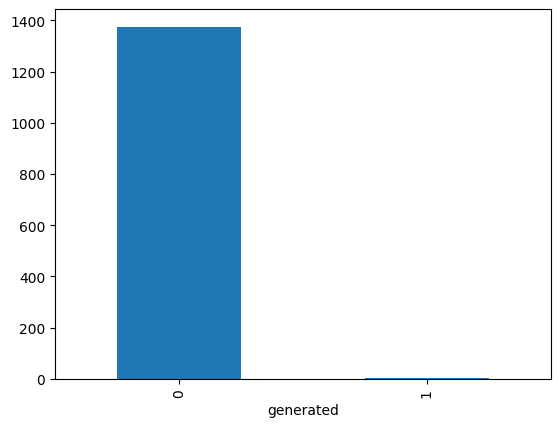

In [31]:
train_df["generated"].value_counts().plot(kind="bar")

In [32]:
train_df["generated"].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

In [33]:
generated_samples = train_df[train_df.generated == 1]

In [34]:
for i in range(len(generated_samples)):
    print("=" * 50)
    print(f"Generated sample {i}")
    print("=" * 50)
    print(generated_samples.iloc[i].text)

Generated sample 0
This essay will analyze, discuss and prove one reason in favor of keeping the Electoral College in the United States for its presidential elections. One of the reasons to keep the electoral college is that it is better for smaller, more rural states to have more influence as opposed to larger metropolitan areas that have large populations. The electors from these states are granted two votes each. Those from larger, more populated areas are granted just one vote each. Smaller states tend to hold significant power because their two votes for president and vice president add up more than the votes of larger states that have many electors. This is because of the split of the electoral votes. Some argue that electors are not bound to vote for the candidate who won the most votes nationally. They do not have to vote for their own state's nominee unless their state has a winner take all system. However, there are states that have adopted laws that force their electors to v

In [35]:
external_dataset_1 = pd.read_csv("/kaggle/input/daigt-external-dataset/daigt_external_dataset.csv")
external_dataset_1["generated"] = 1
external_dataset_1.head()

,id,text,instructions,source_text,generated
0,6060D28C05B6,Some schools in United States ofter classes fr...,\nTask: Write a persuasive essay on whether or...,\nWhen considering the pros and cons of attend...,1
1,60623DB5DE7A,"Four-day work week, a remarkable idea to conse...",\nTask: Research the advantages and disadvanta...,\nOne of the primary arguments for implementin...,1
2,607A39D981DE,Students and their families should consider an...,\nTask: \n\n1. Talk to your parents before tak...,\nBefore making any decisions about getting in...,1
3,60ACDFA1609E,Agree you will never grow if something beyond ...,\nTask: Write an essay discussing the benefits...,"\nRalph Waldo Emerson once said, ""Go confident...",1
4,60AE13D3F07B,I think our character traits are formed by inf...,\nTask: Research and discuss how character tra...,\nHuman character traits are shaped by a wide ...,1


In [36]:
external_dataset_2 = pd.read_csv("/kaggle/input/llm-7-prompt-training-dataset/train_essays_RDizzl3_seven_v1.csv")
external_dataset_2 = external_dataset_2.rename(columns={"label": "generated"})
external_dataset_2.head()

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


In [37]:
columns = ["text", "generated"]
df = pd.concat([train_df[columns], external_dataset_1[columns], external_dataset_2])
df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


<Axes: xlabel='generated'>

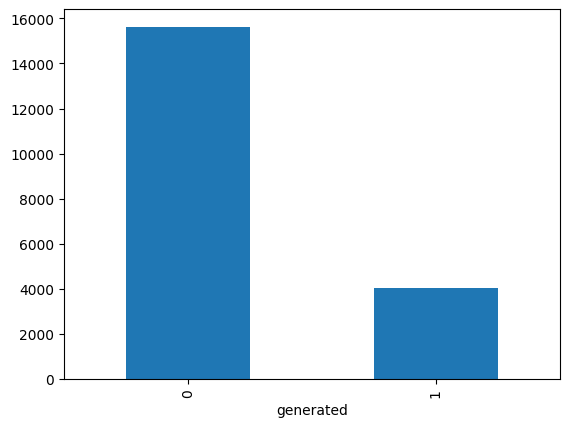

In [38]:
df.generated.value_counts().plot(kind="bar")

In [39]:
class_weights = dict((1 / df.generated.value_counts()) / np.sum(1 / df.generated.value_counts()))
class_weights

{0: 0.2056431113370615, 1: 0.7943568886629385}

In [40]:
def make_dataset(X, y, batch_size, mode):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if mode == "train":
        dataset = dataset.shuffle(batch_size * 4) 
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache(
    ).prefetch(tf.data.AUTOTUNE).repeat(1)
    return dataset

In [41]:
train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df[config.label])

In [42]:
train_ds = make_dataset(train_df["text"], train_df[config.label], batch_size=config.batch_size, mode="train")
valid_ds = make_dataset(valid_df["text"], valid_df[config.label], batch_size=config.batch_size, mode="valid")

In [43]:
for batch in train_ds.take(1):
    print(batch)

(<tf.Tensor: shape=(128,), dtype=string, numpy=
array([b'Dear senator, the system we have today used to elect the president, the Electoral College, must be changed. Instead, we should elect the president by means of a popular vote. The Electoral College is unecessary and complicated, and not to mention, outdated. Source 1 says that the Electoral College was established in the Constitution by the founding fathers. This begs the question, how can a system so old still be practical and in use today? This system, therefore, needs to be replaced by a national popular vote.\n\nThere are so many things that could go wrong with the Electoral College, such as a tie, in which the decision would go to the House of Representatives. According to Source 2, if this were to happen, than, "the single representative from Wyoming, representing 500,000 voters, would have as much say as the 55 representatives from California, who represent 35 million voters." This, of course, would not reflect the nation\'

<a id="7."></a>
## 7. Model Development

In [44]:
def get_model(config):
    encoder = keras_nlp.models.DistilBertBackbone.from_preset(
        config.model_name
    )
    encoder.trainable = False
    preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
        config.model_name
    )
    inputs = keras.Input(shape=(), dtype=tf.string)
    x = preprocessor(inputs)
    x = encoder(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    output = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, output, name="model")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(3e-4), 
        loss="binary_crossentropy", 
        metrics=["accuracy", keras.metrics.AUC(name="auc")]
    )
    return model

Train the model or load model from directory. I will keep track of best models evaluated by different metircs for ensembling.

In [45]:
import tensorflow as tf
from tensorflow import keras

model_paths = ["model_auc.tf"]
models = []

if config.is_training:
    model = get_model(config)
    model.summary()
    model.fit(
        train_ds, 
        epochs=config.epochs, 
        validation_data=valid_ds,
        class_weight=class_weights,
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(patience=5, min_delta=1e-4, min_lr=1e-6),
            keras.callbacks.ModelCheckpoint("model_auc.tf", monitor="val_auc", mode="max", save_best_only=True),
            keras.callbacks.ModelCheckpoint("model_accuracy.tf", monitor="val_accuracy", save_best_only=True),
            keras.callbacks.ModelCheckpoint("model_loss.tf", monitor="val_loss", save_best_only=True),
        ]
    )
    for model_path in model_paths:
        model = keras.layers.TFSMLayer(model_path, call_endpoint='serving_default')
        models.append(model)
else:
    for model_path in model_paths:
        model = keras.layers.TFSMLayer(f"{config.output_dataset_path}/{model_path}", call_endpoint='serving_default')
        models.append(model)

In [47]:
import numpy as np
import pandas as pd

test_data_tensor = tf.convert_to_tensor(test_df["text"])
predictions = []

for model in models:
    result = model(inputs=test_data_tensor)
    prediction_tensor = result['dense'] 
    prediction_numpy = prediction_tensor.numpy()
    predictions.append(prediction_numpy)

mean_prediction = np.mean(predictions, axis=0)
sample_submission = pd.DataFrame()
sample_submission[config.label] = mean_prediction.flatten()
sample_submission.to_csv("submission.csv", index=False)


In [51]:
import numpy as np
import tensorflow as tf

def classify_text(model, text):
    input_tensor = tf.convert_to_tensor([text])
    result = model(input_tensor)
    
    prediction_tensor = result['dense']  

    prediction_numpy = prediction_tensor.numpy()
    classification = "AI-generated" if prediction_numpy[0][0] > 0.7 else "Human-generated"
    
    return classification

user_text = input("Enter the text to classify: ")
for model in models:
    classification = classify_text(model, user_text)
    print(f"Model classification: {classification}")

Enter the text to classify:  One of the most remarkable aspects of flowers is their sheer diversity. From the humble daisy to the majestic rose, from the exotic orchid to the cheerful sunflower, flowers come in a dazzling array of shapes, sizes, and hues. Each variety possesses its own unique charm, captivating beholders with its beauty and intricacy.


Model classification: AI-generated


In [ ]:
sample_submission[config.label].plot(kind="kde")
train_df[config.label].plot(kind="kde")
plt.legend()